In [2]:
%store -r insert_035_88
%store -r inserect_selected_genes
import logging
import math
import numpy as np
import pandas as pd
import numpy as np
from scipy.interpolate import UnivariateSpline
from matplotlib import pyplot as plt
from scipy.stats import rankdata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import rankdata
from collections import Counter
import random 
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import RandomOverSampler
#from imblearn.over_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn import ensemble
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


In [3]:
##给数据集的每一行的最后一列加上类型 
#117+74+40+7+6
cancer_type=np.array([[0]*117+[1]*74+[2]*40+[3]*7+[4]*6],dtype=np.int64)
cancer_type=cancer_type.reshape(-1,1)
##cancer_type is a column array 
patient_np_with_cancer_type=np.hstack((inserect_selected_genes,cancer_type)) 
print(patient_np_with_cancer_type.shape)

(244, 89)


In [4]:
## 原始数据for Lung type 
#把数据的最好一列给0是lung， 1 是其他
Prostate_type=patient_np_with_cancer_type[patient_np_with_cancer_type[:,-1]==3]
Prostate_type[:,-1]=0
other_type_for_Prostate= patient_np_with_cancer_type[patient_np_with_cancer_type[:,-1]!=3]
other_type_for_Prostate[:,-1]=1
print(Prostate_type.shape)
print(other_type_for_Prostate.shape)

(7, 89)
(237, 89)


In [5]:
##把prostate 分成6:1
##重复到40:20 
kfold = KFold(n_splits=7, random_state=None,shuffle=False)
#kfold.get_n_splits(Lung_type[:,:-1], Lung_type[:,-1])
X_train_Prostate_list=[]
X_test_Prostate_list=[]
y_train_Prostate_list=[]
y_test_Prostate_list=[]
for train_index, test_index in kfold.split(Prostate_type[:,:-1], Prostate_type[:,-1]):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = Prostate_type[:,:-1][train_index], Prostate_type[:,:-1][test_index]
    y_train, y_test = Prostate_type[:,-1][train_index], Prostate_type[:,-1][test_index]
    X_train_Prostate_list.append(X_train)
    X_test_Prostate_list.append(X_test)
    y_train_Prostate_list.append(y_train)
    y_test_Prostate_list.append(y_test)

TRAIN: [1 2 3 4 5 6] TEST: [0]
TRAIN: [0 2 3 4 5 6] TEST: [1]
TRAIN: [0 1 3 4 5 6] TEST: [2]
TRAIN: [0 1 2 4 5 6] TEST: [3]
TRAIN: [0 1 2 3 5 6] TEST: [4]
TRAIN: [0 1 2 3 4 6] TEST: [5]
TRAIN: [0 1 2 3 4 5] TEST: [6]


In [6]:
##随机选择不是Prostate的 需要共需要21*7=147个 
np.random.shuffle(other_type_for_Prostate)
##随机取180个数据
used_other_Prostate_ind= np.random.choice(a=237,size=147,replace=False)

array_other_type_for_Prostate=other_type_for_Prostate[used_other_Prostate_ind,:]
print(array_other_type_for_Prostate.shape)

(147, 89)


In [7]:
##把这147是个 分到18:3的7组里面 
ProstateOther_list_train=[]
ProstateOther_list_test=[]

for i in range(7): 
    ProstateOther_list_train.append(array_other_type_for_Prostate[18*i:18*(i+1),:])
    ProstateOther_list_test.append(array_other_type_for_Prostate[126+3*i:126+3*(i+1),:])
   




In [8]:
##把生成的两个类都合在一起 每一个fold——train里面有44个 每一个test里面有22个
fold_train=[]
for i in range(7):
    print(X_train_Prostate_list[i].shape)
    y_train_Prostate_list[i]=y_train_Prostate_list[i].reshape((-1,1))
    print(y_train_Prostate_list[i].shape)
    np.hstack((X_train_Prostate_list[i],y_train_Prostate_list[i]))
    fold_train.append(np.vstack((np.hstack((X_train_Prostate_list[i],y_train_Prostate_list[i])),ProstateOther_list_train[i])))
print(len(fold_train))
print(fold_train[-1].shape)
fold_test=[]
for i in range(7): 
    print(X_test_Prostate_list[i].shape)
    y_test_Prostate_list[i]=y_test_Prostate_list[i].reshape((-1,1))
    print(y_test_Prostate_list[i].shape)
    fold_test.append(np.vstack((np.hstack((X_test_Prostate_list[i],y_test_Prostate_list[i])),ProstateOther_list_test[i])))
print(len(fold_test))
print(fold_test[-1].shape)
    

(6, 88)
(6, 1)
(6, 88)
(6, 1)
(6, 88)
(6, 1)
(6, 88)
(6, 1)
(6, 88)
(6, 1)
(6, 88)
(6, 1)
(6, 88)
(6, 1)
7
(24, 89)
(1, 88)
(1, 1)
(1, 88)
(1, 1)
(1, 88)
(1, 1)
(1, 88)
(1, 1)
(1, 88)
(1, 1)
(1, 88)
(1, 1)
(1, 88)
(1, 1)
7
(4, 89)


In [9]:
## do over sampling给lung在三个train 和三个testset当中 
ros = RandomOverSampler(random_state=0)
X_train_union=[]
y_train_union=[]
X_test_union=[]
y_test_union=[]
for i in range(7):
    X_train_union.append(ros.fit_resample(fold_train[i][:,:-1], fold_train[i][:,-1])[0])
    y_train_union.append(ros.fit_resample(fold_train[i][:,:-1], fold_train[i][:,-1])[1])
    X_test_union.append(ros.fit_resample(fold_test[i][:,:-1], fold_test[i][:,-1])[0])
    y_test_union.append(ros.fit_resample(fold_test[i][:,:-1], fold_test[i][:,-1])[1])

    
    
    



(252, 88)
(42, 88)
[00:40:02] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
88


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
<ipython-input-10-fcb8df7f6f7d>:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfmodel.fit(whole_union_X, whole_union_y)
/Users/chen/opt/anaconda3/lib/p

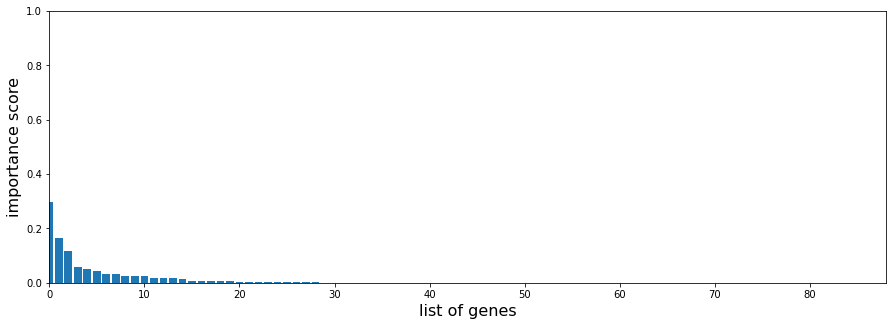

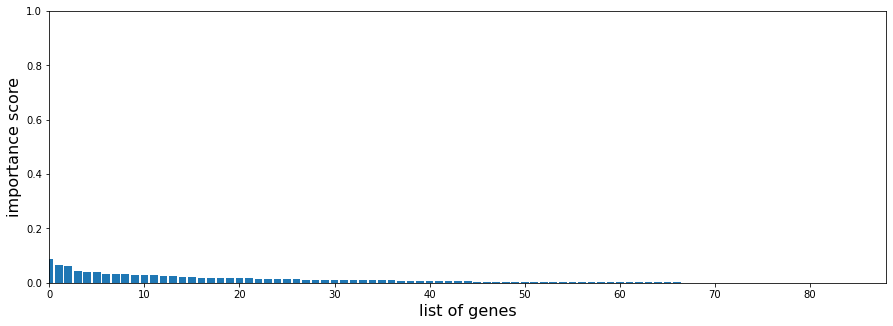

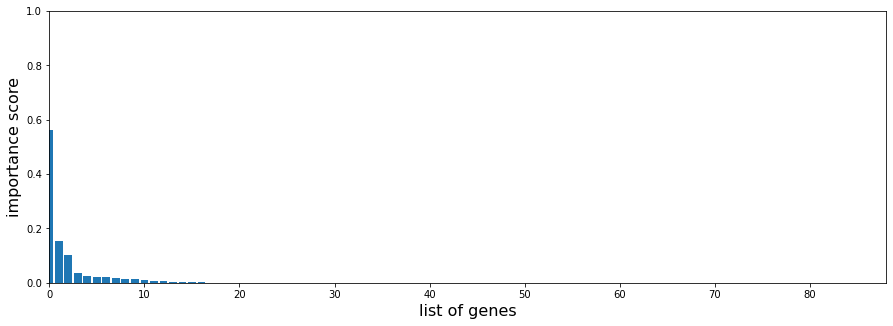

In [10]:
##做whole data set 的 也就是180:180 来看rank 
##生成一个whole data set 
a=np.array(X_train_union).reshape((252,88))
print(a.shape)
b=np.array(X_test_union).reshape((42,88))
print(b.shape)
c=np.array(y_train_union).reshape((252,1))
d=np.array(y_test_union).reshape((42,1))
whole_union_X=np.vstack((a,b))
whole_union_y=np.vstack((c,d))
#print(whole_union_X.shape)


##therefore, I decide to apply union data and inserect data on XGBOOST/RF/gbdt algo. 
##to select gene and see how accaury after selected genes 

##用train set to select gene apply on the test part no cross validation here 
xgbmodel = XGBClassifier(use_label_encoder=True)

##union data on XGBOOST
##用train set to select gene apply on the test part no cross validation here 
xgbmodel.fit(whole_union_X, whole_union_y)
importance_xgbmodel= xgbmodel.feature_importances_
values=list(importance_xgbmodel)
id_symbol_name_bird =list(insert_035_88)
xgb_birdgene_import = dict(zip(insert_035_88, values))
xgb_birdgene_import_important=sorted(xgb_birdgene_import.items(),key = lambda x:x[1],reverse = True)
xgb_birdgene_import_important_adasyn = dict((x, y) for x, y in xgb_birdgene_import_important)
importance_sorted_xgbmodel=sorted(importance_xgbmodel,reverse=True)
print(len(importance_sorted_xgbmodel))
plt.figure(figsize=(15,5))
a= np.arange(0,88,1)
plt.bar(a, importance_sorted_xgbmodel)
plt.ylabel('importance score', fontsize=16)
plt.xlabel('list of genes', fontsize=16)
plt.axis([0, 88, 0, 1])
plt.savefig('XGBOOST_insert_prostate_before.jpg')



##bird data on random forest

rfmodel = ensemble.RandomForestClassifier( oob_score = True,n_jobs = -1,random_state =0)
rfmodel.fit(whole_union_X, whole_union_y)
importance_rfmodel= rfmodel.feature_importances_
values=list(importance_rfmodel)
id_symbol_name_bird =list(insert_035_88)
rf_birdgene_import = dict(zip(insert_035_88, values))
rf_birdgene_import_important=sorted(rf_birdgene_import.items(),key = lambda x:x[1],reverse = True)
rf_birdgene_import_important_adasyn = dict((x, y) for x, y in rf_birdgene_import_important)
importance_sorted_rfmodel=sorted(importance_rfmodel,reverse=True)
plt.figure(figsize=(15,5))
a= np.arange(0,88,1)

plt.bar(a, importance_sorted_rfmodel)
plt.ylabel('importance score', fontsize=16)
plt.xlabel('list of genes', fontsize=16)
plt.axis([0, 88, 0, 1])
plt.savefig('RF_insert_prostate_before.jpg')
## data on GBDT 

gbdtmodel=ensemble.GradientBoostingClassifier()
gbdtmodel.fit(whole_union_X, whole_union_y)
importance_gbdtmodel= gbdtmodel.feature_importances_
values=list(importance_gbdtmodel)
id_symbol_name_bird =list(insert_035_88)
gbdt_birdgene_import = dict(zip(insert_035_88, values))
gbdt_birdgene_import_important=sorted(gbdt_birdgene_import.items(),key = lambda x:x[1],reverse = True)
gbdt_birdgene_import_important_adasyn = dict((x, y) for x, y in gbdt_birdgene_import_important)
importance_sorted_gbdt=sorted(importance_gbdtmodel,reverse=True)
plt.figure(figsize=(15,5))
a= np.arange(0,88,1)

plt.bar(a, importance_sorted_gbdt)
plt.ylabel('importance score', fontsize=16)
plt.xlabel('list of genes', fontsize=16)
plt.axis([0, 88, 0, 1])
plt.savefig('gbdt_insert_prostate_before.jpg')



In [11]:
##删基因
#从important score数值大的开始取 看取到多少 到的一个差不多的accuracy 
#################
##union on xgbmodel
xgbmodel= XGBClassifier(use_label_encoder=True)
xgbmodel.fit(whole_union_X,whole_union_y)
thresholds = sorted(xgbmodel.feature_importances_,reverse = True )
for thresh in thresholds:
    
    accuracy=[]
    for i in range(7):
        selection = SelectFromModel(xgbmodel, threshold=thresh, prefit=True)
        select_train_X = selection.transform(X_train_union[i])
        select_test_X=selection.transform(X_test_union[i])
    
        selection_model = XGBClassifier(use_label_encoder=True)
        selection_model.fit(select_train_X, y_train_union[i])
        y_pred = selection_model.predict(select_test_X)
        accuracy.append( accuracy_score(y_test_union[i], y_pred))
    accu_all_fold=np.mean(accuracy)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_train_X.shape[1],accu_all_fold *100.0))
    
    
##Thresh=0.109, n=3, Accuracy: 83.33%

##Thresh=0.063, n=5, Accuracy: 85.71%




/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:40:06] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:40:06] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:40:06] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:40:07] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:40:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:40:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:40:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:40:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.297, n=1, Accuracy: 66.67%
[00:40:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:

/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:40:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:40:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py

[00:40:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:40:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py

[00:40:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:40:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.166, n=2, Accuracy: 78.57%
[00:40:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:

/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py

[00:40:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:40:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:40:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py

[00:40:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:40:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:40:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py

[00:40:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:40:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:40:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py

[00:40:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:40:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:40:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:40:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.060, n=4, Accuracy: 78.57%


KeyboardInterrupt: 

In [33]:
##################
##bird on random forest 
rfmodel= ensemble.RandomForestClassifier(oob_score = True,n_jobs = -1,random_state =0)

rfmodel.fit(whole_union_X,whole_union_y)

thresholds = sorted(rfmodel.feature_importances_,reverse = True )
for thresh in thresholds:
    # select features using threshold
    
    accuracy=[]
    for i in range(7):
        selection = SelectFromModel(rfmodel, threshold=thresh, prefit=True)
        select_train_X = selection.transform(X_train_union[i])
        select_test_X=selection.transform(X_test_union[i])
    
        selection_model = ensemble.RandomForestClassifier(oob_score = True,n_jobs = -1,random_state =0)
        selection_model.fit(select_train_X, y_train_union[i])
        y_pred = selection_model.predict(select_test_X)
        accuracy.append( accuracy_score(y_test_union[i], y_pred))
    accu_all_fold=np.mean(accuracy)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_train_X.shape[1],accu_all_fold *100.0))
##    
##Thresh=0.043, n=3, Accuracy: 85.71%




<ipython-input-33-54bde6bd62c9>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfmodel.fit(whole_union_X,whole_union_y)


Thresh=0.086, n=1, Accuracy: 73.81%
Thresh=0.058, n=2, Accuracy: 83.33%
Thresh=0.043, n=3, Accuracy: 85.71%
Thresh=0.042, n=4, Accuracy: 80.95%
Thresh=0.042, n=5, Accuracy: 80.95%
Thresh=0.040, n=6, Accuracy: 90.48%


KeyboardInterrupt: 

In [34]:
##################
##union on GBDT
gbdtmodel=ensemble.GradientBoostingClassifier()
gbdtmodel.fit(whole_union_X,whole_union_y)

thresholds = sorted(gbdtmodel.feature_importances_,reverse = True )
for thresh in thresholds:
    # select features using threshold
    
    
   
    accuracy=[]
    for i in range(7):
        selection = SelectFromModel(gbdtmodel, threshold=thresh, prefit=True)
        select_train_X = selection.transform(X_train_union[i])
        select_test_X=selection.transform(X_test_union[i])
    
        selection_model = ensemble.GradientBoostingClassifier()
        selection_model.fit(select_train_X, y_train_union[i])
        y_pred = selection_model.predict(select_test_X)
        accuracy.append( accuracy_score(y_test_union[i], y_pred))
    accu_all_fold=np.mean(accuracy)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_test_X.shape[1],accu_all_fold *100.0))
    

##Thresh=0.041, n=4, Accuracy: 88.10%

   

/Users/chen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Thresh=0.611, n=1, Accuracy: 73.81%
Thresh=0.152, n=2, Accuracy: 80.95%
Thresh=0.075, n=3, Accuracy: 85.71%
Thresh=0.041, n=4, Accuracy: 88.10%
Thresh=0.040, n=5, Accuracy: 85.71%
Thresh=0.019, n=6, Accuracy: 85.71%
Thresh=0.016, n=7, Accuracy: 83.33%
Thresh=0.014, n=8, Accuracy: 71.43%
Thresh=0.011, n=9, Accuracy: 71.43%
Thresh=0.010, n=10, Accuracy: 71.43%
Thresh=0.004, n=11, Accuracy: 71.43%
Thresh=0.003, n=12, Accuracy: 71.43%


KeyboardInterrupt: 

In [12]:
##都取前两个 


##搞出来被选的genes 的list 然后画图
##union_on_XGBOOST

name_of_selected_genes_bird_xgb=[i for i in xgb_birdgene_import_important_adasyn.keys()][:5]
print(name_of_selected_genes_bird_xgb)

index_list=[]
for i in name_of_selected_genes_bird_xgb:
    index_list.append(int(insert_035_88[insert_035_88.values == i].index.values.tolist()[0])
)


location_list_bird_xgb=[]
for i in index_list:
    print(i)
    location_list_bird_xgb.append(insert_035_88.index.get_loc(i))
print(location_list_bird_xgb)

['TBX4', 'HOXD4', 'HOXC9', 'CORO6', 'KRT86']
7380
1211
5642
7544
10418
[34, 26, 2, 66, 24]


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:40:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


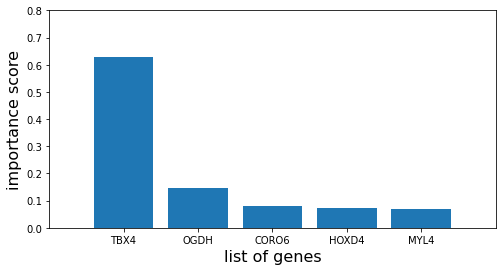

In [13]:
##用 whole data 画图 

xgbmodel.fit(whole_union_X[:,location_list_bird_xgb], whole_union_y)
importance_after_xgb = xgbmodel.feature_importances_
importance_sorted_bird_xgb=sorted(importance_after_xgb,reverse=True)


plt.figure(figsize=(8,4))
interset_prostate_xgb_5gene=['TBX4', 'OGDH', 'CORO6', 'HOXD4', 'MYL4']

plt.bar(interset_prostate_xgb_5gene, importance_sorted_bird_xgb)
plt.ylabel('importance score', fontsize=16)
plt.xlabel('list of genes', fontsize=16)
plt.axis([-1, 5, 0, 0.8])

plt.savefig('intersect-prostate_xgb_5genes_after.jpg')

In [37]:
name_of_selected_genes_bird_rf=[i for i in rf_birdgene_import_important_adasyn.keys()][:3]
print(name_of_selected_genes_bird_rf)

index_list=[]
for i in name_of_selected_genes_bird_rf:
    index_list.append(int(insert_035_88[insert_035_88.values == i].index.values.tolist()[0])
)

    
   
location_list_bird_RF=[]
for i in index_list:
    print(i)
    location_list_bird_RF.append(insert_035_88.index.get_loc(i))
print(location_list_bird_RF)



['TBX4', 'OGDH', 'CCL11']
7380
3469
7278
[34, 71, 16]


<ipython-input-38-d4a9c53812cd>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfmodel.fit(whole_union_X[:,location_list_bird_RF], whole_union_y)


3


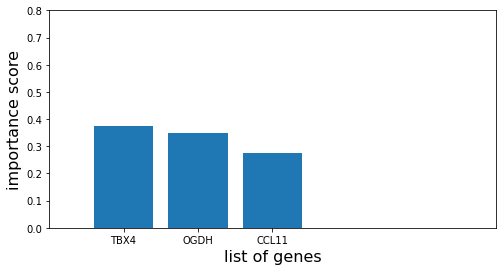

In [38]:
rfmodel.fit(whole_union_X[:,location_list_bird_RF], whole_union_y)
importance_adasyn = rfmodel.feature_importances_
importance_sorted=sorted(importance_adasyn,reverse=True)

values=list(importance_sorted)
rf_birdgene_import = dict(zip(insert_035_88.iloc[location_list_bird_RF], values))
rf_birdgene_import_important=sorted(rf_birdgene_import.items(),key = lambda x:x[1],reverse = True)
rf_birdgene_import_important_adasyn = dict((x, y) for x, y in rf_birdgene_import_important)

print(len(importance_sorted))
plt.figure(figsize=(8,4))
interset_pro_rf_3gene=['TBX4', 'OGDH', 'CCL11']
plt.bar(interset_pro_rf_3gene, importance_sorted)
plt.ylabel('importance score', fontsize=16)
plt.xlabel('list of genes', fontsize=16)
plt.axis([-1, 5, 0, 0.8])

plt.savefig('intersect_prostate_rf_3genes_after.jpg')

In [39]:
name_of_selected_genes_bird_gbdt=[i for i in gbdt_birdgene_import_important_adasyn.keys()][:4]
print(name_of_selected_genes_bird_gbdt)

index_list=[]
for i in name_of_selected_genes_bird_gbdt:
    index_list.append(int(insert_035_88[insert_035_88.values == i].index.values.tolist()[0])
)

    
   
location_list_bird_gbdt=[]
for i in index_list:
    print(i)
    location_list_bird_gbdt.append(insert_035_88.index.get_loc(i))
print(location_list_bird_gbdt)

['TBX4', 'CORO6', 'MYL4', 'WDR45']
7380
7544
12134
9427
[34, 66, 64, 33]


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


4


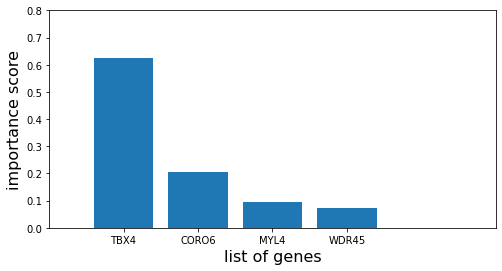

In [40]:
gbdtmodel.fit(whole_union_X[:,location_list_bird_gbdt], whole_union_y)
importance_adasyn = gbdtmodel.feature_importances_
importance_sorted=sorted(importance_adasyn,reverse=True)

values=list(importance_sorted)
gbdt_birdgene_import = dict(zip(insert_035_88.iloc[location_list_bird_gbdt], values))
gbdt_birdgene_import_important=sorted(gbdt_birdgene_import.items(),key = lambda x:x[1],reverse = True)
gbdt_birdgene_import_important_adasyn = dict((x, y) for x, y in gbdt_birdgene_import_important)

print(len(importance_sorted))
plt.figure(figsize=(8,4))
gbdt_pro_4gene=['TBX4', 'CORO6', 'MYL4', 'WDR45']
plt.bar(gbdt_pro_4gene, importance_sorted)
plt.ylabel('importance score', fontsize=16)
plt.xlabel('list of genes', fontsize=16)
plt.axis([-1, 5, 0, 0.8])

plt.savefig('insert_gbdt_prostate 4genes_after.jpg')


In [41]:
##confusion matrix balanced data 
#
#rfmodel = ensemble.RandomForestClassifier( oob_score = True,n_jobs = -1,random_state =0)
#gbdtmodel
#xgbmodel
y_pred_xgb=[]
y_pred_rf=[]
y_pred_gbdt=[]
accuracy_xgb=[]
accuracy_rf=[]
accuracy_gbdt=[]
y_test_list=[]
pred_whole_list_xbg=[]
pred_whole_list_rf=[]
pred_whole_list_gbdt=[]
for i in range(7): 
    X_rf=X_train_union[i][:,location_list_bird_RF]
    X_xgb=X_train_union[i][:,location_list_bird_xgb] 
    X_gbdt=X_train_union[i][:,location_list_bird_gbdt]
    y=y_train_union[i].ravel()
    xgbmodel= XGBClassifier(use_label_encoder=True)

    xgbmodel.fit(X_xgb,y)
    rfmodel.fit(X_rf,y)
    gbdtmodel.fit(X_gbdt,y)
    
   
    
    y_pred_xgb.append(xgbmodel.predict(X_test_union[i][:,location_list_bird_xgb]))
    y_pred_rf.append(rfmodel.predict(X_test_union[i][:,location_list_bird_RF]))
    y_pred_gbdt.append(gbdtmodel.predict(X_test_union[i][:,location_list_bird_gbdt]))

    accuracy_xgb.append(accuracy_score(y_test_union[i], y_pred_xgb[i]))
    accuracy_rf.append(accuracy_score(y_test_union[i], y_pred_rf[i]))
    accuracy_gbdt.append(accuracy_score(y_test_union[i], y_pred_gbdt[i]))
   
    for j in range (len(y_test_union[i])):
        y_test_list.append(int(y_test_union[i][j]))
        
        pred_whole_list_xbg.append(y_pred_xgb[i].tolist()[j])
        pred_whole_list_rf.append(y_pred_rf[i].tolist()[j])
        pred_whole_list_gbdt.append(y_pred_gbdt[i].tolist()[j])


    
    
accuracy_total_xgb = np.mean(accuracy_xgb)
accuracy_total_rf = np.mean(accuracy_rf)
accuracy_total_gbdt = np.mean(accuracy_gbdt)




print("Accuracy xgb: %.2f%%" % (accuracy_total_xgb * 100.0))    
print("Accuracy rf: %.2f%%" % (accuracy_total_rf * 100.0))  
print("Accuracy gbdt: %.2f%%" % (accuracy_total_gbdt * 100.0))    




/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:52] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:52] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:53] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:54] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:54] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy xgb: 88.10%
Accuracy rf: 83.33%
Accuracy gbdt: 88.10%


[[21  0]
 [ 5 16]]
for xgb [0.80769231 1.        ]
[1.         0.76190476]
[0.89361702 0.86486486]
[[18  3]
 [ 4 17]]
for rf [0.81818182 0.85      ]
[0.85714286 0.80952381]
[0.8372093  0.82926829]
[[21  0]
 [ 5 16]]
for gbdt [0.80769231 1.        ]
[1.         0.76190476]
[0.89361702 0.86486486]


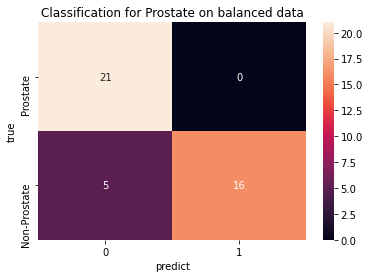

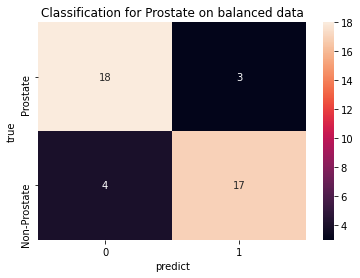

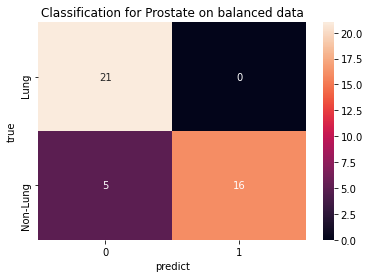

In [42]:
C_xgb=confusion_matrix(y_test_list, pred_whole_list_xbg,labels=[ 0.,1.])
print(C_xgb)
f,ax=plt.subplots()

sns.heatmap(C_xgb,annot=True, fmt ='g',ax=ax,yticklabels =['Prostate','Non-Prostate']) #画热力图

ax.set_title('Classification for Prostate on balanced data') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('true') #y轴
plt.savefig('xgb_intersect_Pro_bal.jpg')

print('for xgb',precision_score(y_test_list, pred_whole_list_xbg, average=None)) 
print(recall_score(y_test_list, pred_whole_list_xbg, average=None))  
print(f1_score(y_test_list, pred_whole_list_xbg, average=None)) 

C_rf=confusion_matrix(y_test_list, pred_whole_list_rf,labels=[ 0.,1.])
print(C_rf)
f,ax=plt.subplots()

sns.heatmap(C_rf,annot=True, fmt ='g',ax=ax,yticklabels =['Prostate','Non-Prostate']) #画热力图

ax.set_title('Classification for Prostate on balanced data') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('true') #y轴
plt.savefig('rf_intersect_pro_bal.jpg')

print('for rf',precision_score(y_test_list, pred_whole_list_rf, average=None)) 
print(recall_score(y_test_list, pred_whole_list_rf, average=None))  
print(f1_score(y_test_list, pred_whole_list_rf, average=None)) 

C_gbdt=confusion_matrix(y_test_list, pred_whole_list_gbdt,labels=[ 0.,1.])
print(C_gbdt)
f,ax=plt.subplots()

sns.heatmap(C_gbdt,annot=True, fmt ='g',ax=ax,yticklabels =['Lung','Non-Lung']) #画热力图

ax.set_title('Classification for Prostate on balanced data') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('true') #y轴
plt.savefig('gbdt_intersect_pto_bal.jpg')

print('for gbdt',precision_score(y_test_list, pred_whole_list_gbdt, average=None)) 
print(recall_score(y_test_list, pred_whole_list_gbdt, average=None))  
print(f1_score(y_test_list, pred_whole_list_gbdt, average=None)) 


In [43]:
##confusion matrix unbalanced data 

##gbdt
#生成一个 0 1 classification的data set 
original_01=np.vstack((Prostate_type,other_type_for_Prostate))
print(original_01.shape)
skf  =StratifiedKFold(n_splits=7, random_state=0,shuffle=True)
X=original_01

y=original_01[:,-1]
skf.get_n_splits(X, y)
y_test_list = []
pred_whole_list_xgb=[]
pred_whole_list_rf=[]
pred_whole_list_gbdt=[]


for train_index, test_index in skf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    gbdtmodel.fit(X_train[:,location_list_bird_gbdt],y_train)
    y_pred_gbdt = gbdtmodel.predict(X_test[:,location_list_bird_gbdt])
    xgbmodel.fit(X_train[:,location_list_bird_xgb],y_train)
    y_pred_xgb=xgbmodel.predict(X_test[:,location_list_bird_xgb])
    rfmodel.fit(X_train[:,location_list_bird_RF],y_train)
    y_pred_rf=rfmodel.predict(X_test[:,location_list_bird_RF])
    
    accuracy_xgb= accuracy_score(y_test, y_pred_xgb)
    accuracy_rf=accuracy_score(y_test, y_pred_rf)
    accuracy_gbdt=accuracy_score(y_test, y_pred_gbdt)
    for i in range (len(y_test)):
        y_test_list.append(int(y_test[i]))
        #print('y_test',y_test_list)
        ##Y-test_true  is y_test_list
   # print("pred",y_pred)
        pred_whole_list_xgb.append(y_pred_xgb.tolist()[i])
        pred_whole_list_rf.append(y_pred_rf.tolist()[i])
        pred_whole_list_gbdt.append(y_pred_gbdt.tolist()[i])


    
    
print(len(pred_whole_list_xgb))
accuracy_all_xgb = accuracy_score(y_test_list, pred_whole_list_xgb)
accuracy_all_rf = accuracy_score(y_test_list, pred_whole_list_rf)
accuracy_all_gbdt = accuracy_score(y_test_list, pred_whole_list_gbdt)


print("Accuracy xgb: %.2f%%" % (accuracy_all_xgb * 100.0))    
print("Accuracy rf: %.2f%%" % (accuracy_all_rf * 100.0))    
print("Accuracy gbdt: %.2f%%" % (accuracy_all_gbdt * 100.0))    









(244, 89)
[19:08:03] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:08:04] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:08:05] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:08:05] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:08:06] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:08:06] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:08:07] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
244
Accuracy xgb: 96.31%
Accuracy rf: 97.13%
Accuracy gbdt: 95.08%


[[  0   7]
 [  2 235]]
for xgb [0.         0.97107438]
[0.         0.99156118]
[0.         0.98121086]
[[  0   7]
 [  0 237]]


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for rf [0.         0.97131148]
[0. 1.]
[0.         0.98544699]
[[  1   6]
 [  6 231]]
for gbdt [0.14285714 0.97468354]
[0.14285714 0.97468354]
[0.14285714 0.97468354]


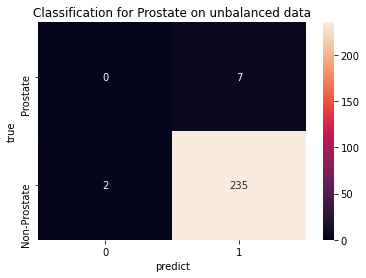

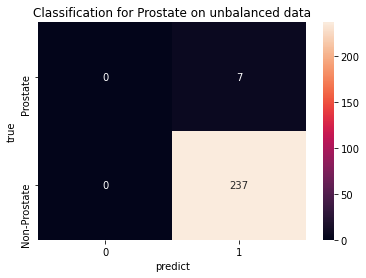

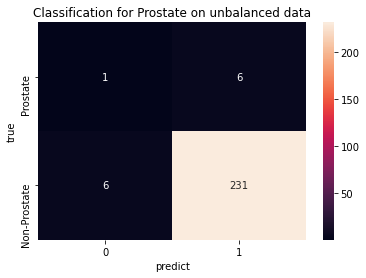

In [44]:
C_xgb=confusion_matrix(y_test_list, pred_whole_list_xgb,labels=[ 0.,1.])
print(C_xgb)
f,ax=plt.subplots()

sns.heatmap(C_xgb,annot=True, fmt ='g',ax=ax,yticklabels =['Prostate','Non-Prostate']) #画热力图

ax.set_title('Classification for Prostate on unbalanced data') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('true') #y轴
plt.savefig('xgb_inserect_pro_ori.jpg')

print('for xgb',precision_score(y_test_list, pred_whole_list_xgb, average=None)) 
print(recall_score(y_test_list, pred_whole_list_xgb, average=None))  
print(f1_score(y_test_list, pred_whole_list_xgb, average=None)) 

C_rf=confusion_matrix(y_test_list, pred_whole_list_rf,labels=[ 0.,1.])
print(C_rf)
f,ax=plt.subplots()

sns.heatmap(C_rf,annot=True, fmt ='g',ax=ax,yticklabels =['Prostate','Non-Prostate']) #画热力图

ax.set_title('Classification for Prostate on unbalanced data') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('true') #y轴
plt.savefig('rf_inserect-ori_pro.jpg')

print('for rf',precision_score(y_test_list, pred_whole_list_rf, average=None)) 
print(recall_score(y_test_list, pred_whole_list_rf, average=None))  
print(f1_score(y_test_list, pred_whole_list_rf, average=None)) 

C_gbdt=confusion_matrix(y_test_list, pred_whole_list_gbdt,labels=[ 0.,1.])
print(C_gbdt)
f,ax=plt.subplots()

sns.heatmap(C_gbdt,annot=True, fmt ='g',ax=ax,yticklabels =['Prostate','Non-Prostate']) #画热力图

ax.set_title('Classification for Prostate on unbalanced data') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('true') #y轴
plt.savefig('gbdt_inserect_pro_ori.jpg')

print('for gbdt',precision_score(y_test_list, pred_whole_list_gbdt, average=None)) 
print(recall_score(y_test_list, pred_whole_list_gbdt, average=None))  
print(f1_score(y_test_list, pred_whole_list_gbdt, average=None)) 
